In [2]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point
import seaborn as sns
import contextily as ctx
import matplotlib.cm as cm
import matplotlib.colors as colors
from scipy.stats import entropy
# from statsmodels.graphics.mosaicplot import mosaic
from scipy.stats import chi2_contingency

cmap = plt.get_cmap('viridis', 5)  # 5 discrete colors

city='sanfrancisco'

def dominant_and_percentage_and_count(x):
    mode_vals = pd.Series.mode(x)
    if mode_vals.empty:
        mode_val = None
        pct = 0.0
    else:
        mode_val = mode_vals.iloc[0].min()
        pct = (x == mode_val).mean() * 100
    count = pd.Series.count(x)
    return pd.Series({'dominant_class': int(mode_val), 'dominant_pct': pct, 'count': count})

### Get Gentrification Index

In [3]:
census_tracts =  gpd.read_file('../../../data/SpatialData/SanFran/GentrificationIndex_SpatialDomain.shp')
census_tracts = census_tracts[census_tracts['Typology']!= 'Unavailable or Unreliable Data']

### Get gentrification scores, convert to geodataframe

In [4]:
base_dir = os.path.expanduser(f"../../../data/AirbnbData/airbnb-{city}/")
scores_per_listing = pd.read_csv(base_dir + 'airbnb_gentrification_scores_categorical_combined_listings_filtered_04.csv')
scores_per_listing['geometry'] = scores_per_listing.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
scores_per_listing_gdf = gpd.GeoDataFrame(scores_per_listing, geometry='geometry', crs="EPSG:4326")
mapping = {'Na': 0,'Undeveloped': 1, 'Emerging': 2, 'Gentrifying': 3, 'Established': 4}
scores_per_listing_gdf['gentrification_prediction_code'] = scores_per_listing_gdf['gentrification_prediction'].map(mapping)

### Get summary score (mode) for each suburb

In [5]:
scores_per_listing_gdf = scores_per_listing_gdf[['latitude', 'longitude', 'geometry', 'gentrification_prediction', 'gentrification_prediction_code', 'explanation']]
scores_per_listing_gdf_with_tract_within = gpd.sjoin(scores_per_listing_gdf, census_tracts[['GEOID', 'geometry']], how='inner', predicate='within')

In [6]:
per_LSOA_summary = (scores_per_listing_gdf_with_tract_within.groupby("GEOID")["gentrification_prediction_code"]
    .apply(dominant_and_percentage_and_count).unstack().reset_index())

### Combine index and LLM scores

In [7]:
per_LSOA_summary = census_tracts[['GEOID', 'Type_code']].merge(per_LSOA_summary, on='GEOID')

In [8]:
crosstab = pd.crosstab(per_LSOA_summary['dominant_class'], per_LSOA_summary['Type_code'])

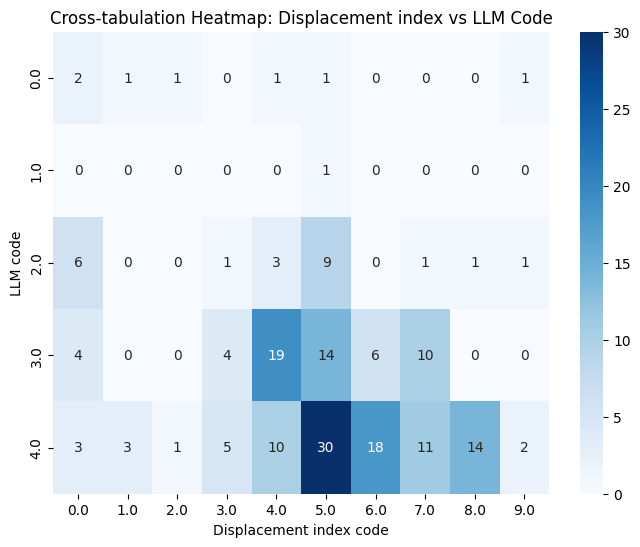

In [9]:
plt.figure(figsize=(8, 6))
sns.heatmap(crosstab, annot=True, fmt='d', cmap='Blues')
plt.title('Cross-tabulation Heatmap: Displacement index vs LLM Code')
plt.xlabel('Displacement index code')
plt.ylabel('LLM code')
plt.show()

In [10]:
mapping = {'Na': 0,'Undeveloped': 1, 'Emerging': 2, 'Gentrifying': 3, 'Established': 4}
mapping_idx = {'Low-Income/Susceptible to Displacement': 0,'Ongoing Displacement': 1, 'At Risk of Gentrification': 2, 
           'Early/Ongoing Gentrification': 3, 'Advanced Gentrification': 4, 'Stable Moderate/Mixed Income':5,
          'At Risk of Becoming Exclusive':6, 'Becoming Exclusive':7, 'Stable/Advanced Exclusive':8, 'High Student Population':9}

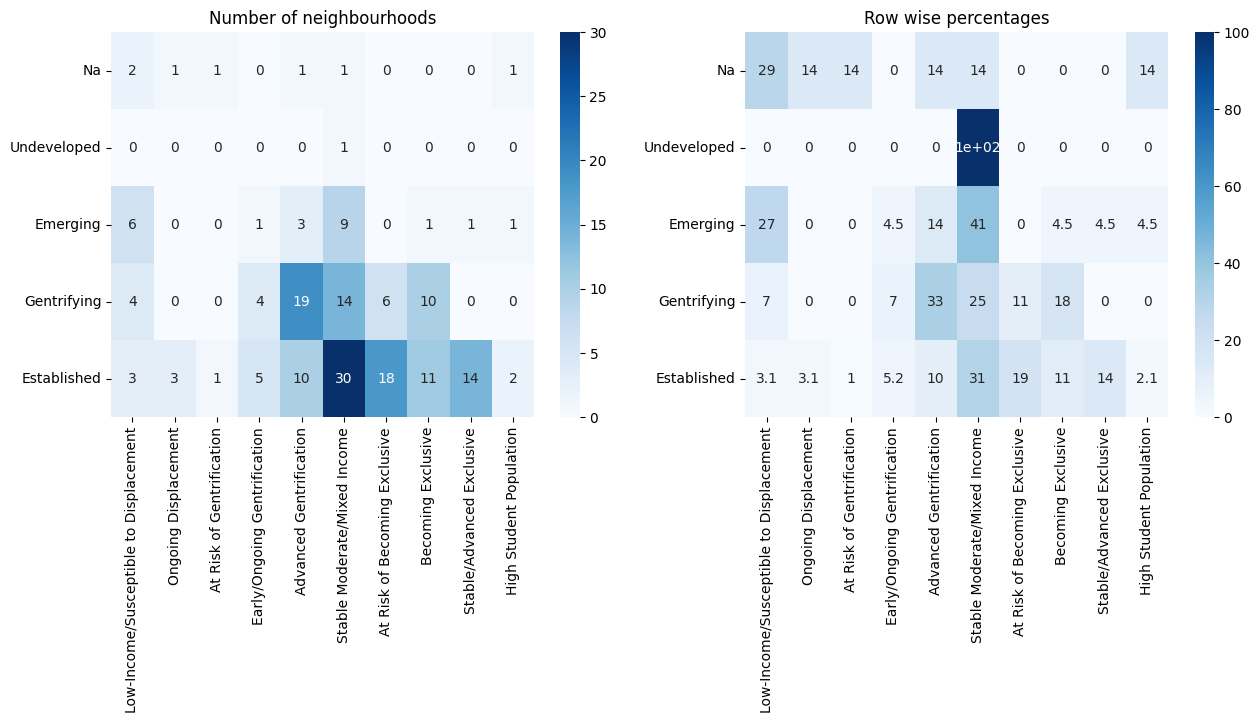

In [11]:
crosstab = pd.crosstab(per_LSOA_summary['dominant_class'], per_LSOA_summary['Type_code'])
inv_mapping = {v: k for k, v in mapping.items()}
inv_mapping_idx = {v: k for k, v in mapping_idx.items()}
crosstab.rename(index=inv_mapping, columns=inv_mapping_idx, inplace=True)
crosstab_row_pct = crosstab.div(crosstab.sum(axis=1), axis=0) * 100

fig,axs=plt.subplots(ncols=2, figsize=(15,5))
sns.heatmap(crosstab, ax=axs[0], annot=True, cmap='Blues')
axs[0].set_title("Number of neighbourhoods")
axs[0].set_xlabel("")
axs[0].set_ylabel("")
sns.heatmap(crosstab_row_pct, ax=axs[1], annot=True, cmap='Blues')
axs[1].set_xlabel("")
axs[1].set_ylabel("")
axs[1].set_title("Row wise percentages");
fig.savefig("../Figures/SanFran_CrossTab.png", bbox_inches = 'tight')

### Bar charts

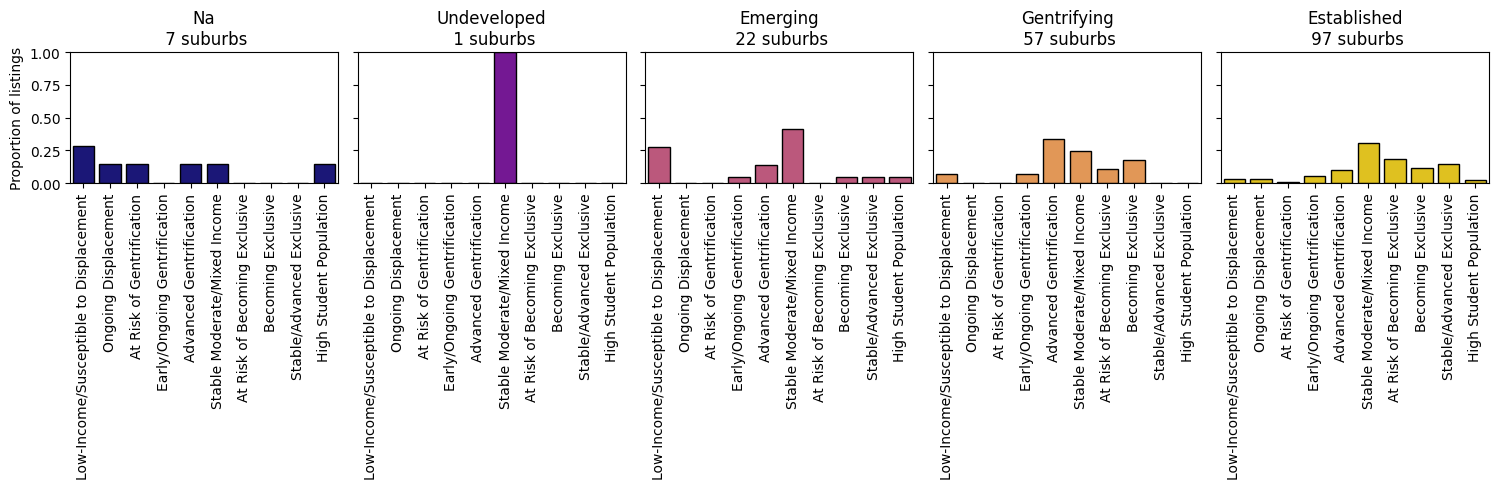

In [94]:
reversed_mapping = {v: k for k, v in mapping.items()}
reversed_mapping_idx = {v: k for k, v in mapping_idx.items()}

# order of categories in the desired plotting sequence
order = list(reversed_mapping_idx.values())

cmap = plt.get_cmap('plasma', 5)
plot_colors = [cmap(i) for i in range(5)]
plot_colors[4] = 'gold'

fig, axs = plt.subplots(ncols=5, figsize=(15,5), sharey=True)

for gentr_class, ax in enumerate(axs.flatten()):
    class0 = per_LSOA_summary[
        per_LSOA_summary['dominant_class'] == gentr_class].copy()

    class0['dominant_class_name'] = class0['dominant_class'].map(reversed_mapping)
    class0['Classification_name'] = class0['Type_code'].map(reversed_mapping_idx)
    if class0.empty:
        # ax.set_axis_off()
        pass
    else:
        # compute proportions
        proportions = (
            class0['Classification_name']
            .value_counts(normalize=True)  # normalize=True → gives proportions
            .reindex(order, fill_value=0)  # ensure consistent category order
        )

        sns.barplot(
            x=proportions.index,
            y=proportions.values,
            ax=ax,
            color=plot_colors[gentr_class],
            edgecolor='black'
        )

        ax.set_ylim(0, 1)  # proportion scale
        ax.set_ylabel('Proportion of listings' if gentr_class == 0 else '')  # only first subplot
        ax.set_xlabel('')
        ax.set_title(f"{class0['dominant_class_name'].unique()[0]}\n {len(class0)} suburbs")
        ax.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()
fig.savefig("../Figures/SanFrancisco_CountPerGroup.png", bbox_inches = 'tight')

In [61]:
# scores_per_listing_gdf_with_tract_within_and_gi_score = scores_per_listing_gdf_with_tract_within[['GEOID', 'gentrification_prediction_code', 'gentrification_prediction']].merge(census_tracts, on='GEOID')

# mapping_idx = {'Low-Income/Susceptible to Displacement': 0,'Ongoing Displacement': 1, 'At Risk of Gentrification': 2, 
#            'Early/Ongoing Gentrification': 3, 'Advanced Gentrification': 4, 'Stable Moderate/Mixed Income':5,
#           'At Risk of Becoming Exclusive':6, 'Becoming Exclusive':7, 'Stable/Advanced Exclusive':8, 'High Student Population':9}

# order = list(mapping_idx.keys())

# cmap = plt.get_cmap('plasma', 5)  # 5 discrete colors
# plot_colors = [cmap(i) for i in range(5)]
# plot_colors[4] = 'gold'

# fig, axs = plt.subplots(ncols=5, figsize=(15,5), sharey=True)

# for gentr_class, ax in enumerate(axs.flatten()):
#     class0 = scores_per_listing_gdf_with_tract_within_and_gi_score[
#         scores_per_listing_gdf_with_tract_within_and_gi_score['gentrification_prediction_code'] == gentr_class]
    
#     if class0.empty:
#         # ax.set_axis_off()
#         pass
#     else:
#         sns.countplot(x='Typology', data=class0, ax=ax, edgecolor='black', order=order, color=plot_colors[gentr_class])
#         ax.set_xlabel('')
#         ax.set_title(class0['gentrification_prediction'].unique()[0])
#         # ✅ rotate x tick labels for *this* subplot only
#         for label in ax.get_xticklabels():
#             label.set_rotation(90)

# plt.tight_layout()
# plt.show()
